#📌 Extracción

In [37]:
import sys
import pandas as pd
sys.path.append('../src')

from etl import cargar_datos_desde_api

url = 'https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json'
df = cargar_datos_desde_api(url)

df.head()

✅ Datos cargados correctamente.


,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


#🔧 Transformación

In [ ]:
# 📦 0. Importación necesaria
import pandas as pd
import json

# 📥 Cargar los datos desde archivo local (ajusta la ruta si es necesario)
with open('../data/TelecomX_Data.json', 'r', encoding='utf-8') as f:
    data_json = json.load(f)

df = pd.json_normalize(data_json)

#  1. Explorar estructura del dataset
print("🧾 Columnas en el dataset:")
print(df.columns.tolist())

print("\n🔍 Tipos de datos:")
print(df.dtypes)

print("\n❓ Valores nulos por columna:")
print(df.isnull().sum())

#  2. Columnas clave para el análisis de evasión
columnas_clave = [
    'Churn',
    'customer.SeniorCitizen',
    'customer.Partner',
    'customer.Dependents',
    'customer.tenure',
    'internet.InternetService',
    'internet.TechSupport',
    'internet.StreamingTV',
    'account.Contract',
    'account.PaymentMethod',
    'account.Charges.Monthly',
    'account.Charges.Total'
]

print("\n Vista previa de variables relevantes:")
display(df[columnas_clave].head())

#  3. Renombrar columnas
df.columns = df.columns.str.replace('.', '_', regex=False)
df.columns = df.columns.str.replace(' ', '_')
df.columns = df.columns.str.lower()

#  4. Conversión de tipos numéricos
df['account_charges_monthly'] = pd.to_numeric(df['account_charges_monthly'], errors='coerce')
df['account_charges_total'] = pd.to_numeric(df['account_charges_total'], errors='coerce')
df['customer_seniorcitizen'] = df['customer_seniorcitizen'].astype(int)

#  5. Validación de calidad de datos
duplicados = df.duplicated()
print(f"\n🔁 Filas duplicadas: {duplicados.sum()}")
print("\n❓ Valores nulos por columna:")
print(df.isnull().sum())

print("\n🔢 Nulos en columnas numéricas:")
print(df[['account_charges_monthly', 'account_charges_total']].isnull().sum())

columnas_categoricas = [
    'churn',
    'internet_internetservice',
    'internet_techsupport',
    'internet_streamingtv',
    'account_contract',
    'account_paymentmethod'
]

for col in columnas_categoricas:
    print(f"\n📋 Valores únicos en '{col}':")
    print(df[col].value_counts(dropna=False))

#  6. Correcciones
df = df.drop_duplicates()

columnas_a_limpieza = columnas_categoricas.copy()
for col in columnas_a_limpieza:
    df[col] = df[col].astype(str).str.strip().str.lower()

df['account_charges_monthly'] = df['account_charges_monthly'].fillna(0)
df['account_charges_total'] = df['account_charges_total'].fillna(0)

for col in columnas_a_limpieza:
    df[col] = df[col].fillna('desconocido')

print("\n✅ Correcciones aplicadas. Datos listos para análisis.")

#  7. Crear columna 'cuentas_diarias'
df['cuentas_diarias'] = df['account_charges_monthly'] / 30

print("\n🆕 Columna 'cuentas_diarias' creada:")
display(df[['account_charges_monthly', 'cuentas_diarias']].head())

#  8. Estandarización adicional
valores_binarios = ['churn', 'customer_partner', 'customer_dependents']

for col in valores_binarios:
    df[col] = df[col].map({'sí': 1, 'si': 1, 'yes': 1, 'no': 0, 'no ': 0}).fillna(df[col])

df['account_contract'] = df['account_contract'].replace({
    'month-to-month': 'mensual',
    'one year': '1 año',
    'two year': '2 años'
})

df['internet_internetservice'] = df['internet_internetservice'].replace({
    'dsl': 'DSL',
    'fiber optic': 'Fibra',
    'no': 'Sin internet'
})

print("\n🎯 Estandarización completada:")
display(df[['churn', 'customer_partner', 'customer_dependents', 'account_contract', 'internet_internetservice']].head())


🧾 Columnas en el dataset:
['customerID', 'Churn', 'customer.gender', 'customer.SeniorCitizen', 'customer.Partner', 'customer.Dependents', 'customer.tenure', 'phone.PhoneService', 'phone.MultipleLines', 'internet.InternetService', 'internet.OnlineSecurity', 'internet.OnlineBackup', 'internet.DeviceProtection', 'internet.TechSupport', 'internet.StreamingTV', 'internet.StreamingMovies', 'account.Contract', 'account.PaperlessBilling', 'account.PaymentMethod', 'account.Charges.Monthly', 'account.Charges.Total']

🔍 Tipos de datos:
customerID                    object
Churn                         object
customer.gender               object
customer.SeniorCitizen         int64
customer.Partner              object
customer.Dependents           object
customer.tenure                int64
phone.PhoneService            object
phone.MultipleLines           object
internet.InternetService      object
internet.OnlineSecurity       object
internet.OnlineBackup         object
internet.DeviceProtection

,Churn,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,internet.InternetService,internet.TechSupport,internet.StreamingTV,account.Contract,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,No,0,Yes,Yes,9,DSL,Yes,Yes,One year,Mailed check,65.6,593.3
1,No,0,No,No,9,DSL,No,No,Month-to-month,Mailed check,59.9,542.4
2,Yes,0,No,No,4,Fiber optic,No,No,Month-to-month,Electronic check,73.9,280.85
3,Yes,1,Yes,No,13,Fiber optic,No,Yes,Month-to-month,Electronic check,98.0,1237.85
4,Yes,1,Yes,No,3,Fiber optic,Yes,Yes,Month-to-month,Mailed check,83.9,267.4



 Filas duplicadas: 0

  Valores nulos por columna:
customerid                    0
churn                         0
customer_gender               0
customer_seniorcitizen        0
customer_partner              0
customer_dependents           0
customer_tenure               0
phone_phoneservice            0
phone_multiplelines           0
internet_internetservice      0
internet_onlinesecurity       0
internet_onlinebackup         0
internet_deviceprotection     0
internet_techsupport          0
internet_streamingtv          0
internet_streamingmovies      0
account_contract              0
account_paperlessbilling      0
account_paymentmethod         0
account_charges_monthly       0
account_charges_total        11
dtype: int64

 Nulos en columnas numéricas:
account_charges_monthly     0
account_charges_total      11
dtype: int64

 Valores únicos en 'churn':
churn
No     5174
Yes    1869
        224
Name: count, dtype: int64

 Valores únicos en 'internet_internetservice':
internet_inter

,account_charges_monthly,cuentas_diarias
0,65.6,2.186667
1,59.9,1.996667
2,73.9,2.463333
3,98.0,3.266667
4,83.9,2.796667



 Estandarización completada.


,churn,customer_partner,customer_dependents,account_contract,internet_internetservice
0,0.0,Yes,Yes,1 año,DSL
1,0.0,No,No,mensual,DSL
2,1.0,No,No,mensual,Fibra
3,1.0,Yes,No,mensual,Fibra
4,1.0,Yes,No,mensual,Fibra


#📊 Carga y análisis

📊 Estadísticas descriptivas globales:


,count,mean,std,min,25%,50%,75%,max
customer_seniorcitizen,7267.0,0.162653,0.369074,0.000000,0.000000,0.000000,0.000000,1.000000
customer_tenure,7267.0,32.346498,24.571773,0.000000,9.000000,29.000000,55.000000,72.000000
account_charges_monthly,7267.0,64.720098,30.129572,18.250000,35.425000,70.300000,89.875000,118.750000
account_charges_total,7267.0,2277.182035,2268.648587,0.000000,396.200000,1389.200000,3778.525000,8684.800000
cuentas_diarias,7267.0,2.157337,1.004319,0.608333,1.180833,2.343333,2.995833,3.958333



📌 Estadísticas para 'customer_tenure':
  - Media: 32.35
  - Mediana: 29.00
  - Desviación estándar: 24.57
  - Valor mínimo: 0.00
  - Valor máximo: 72.00

📌 Estadísticas para 'account_charges_monthly':
  - Media: 64.72
  - Mediana: 70.30
  - Desviación estándar: 30.13
  - Valor mínimo: 18.25
  - Valor máximo: 118.75

📌 Estadísticas para 'account_charges_total':
  - Media: 2277.18
  - Mediana: 1389.20
  - Desviación estándar: 2268.65
  - Valor mínimo: 0.00
  - Valor máximo: 8684.80

📌 Estadísticas para 'cuentas_diarias':
  - Media: 2.16
  - Mediana: 2.34
  - Desviación estándar: 1.00
  - Valor mínimo: 0.61
  - Valor máximo: 3.96


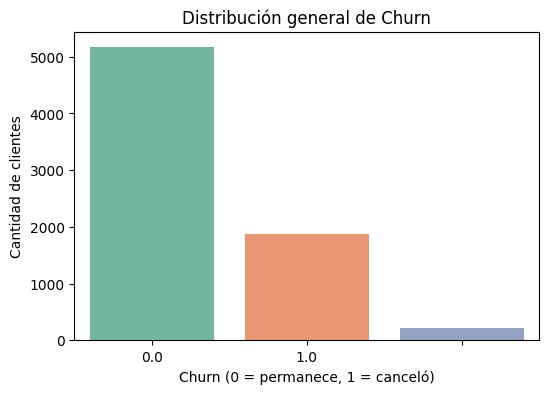


📊 Porcentaje de clientes (churn):
churn
0.0    71.198569
1.0    25.719004
        3.082427
Name: proportion, dtype: float64


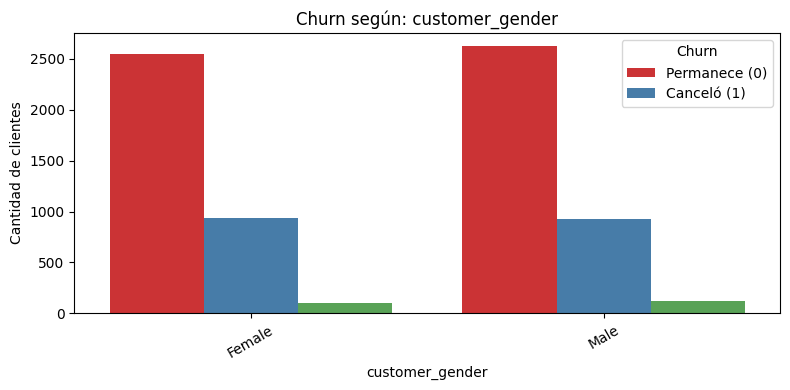

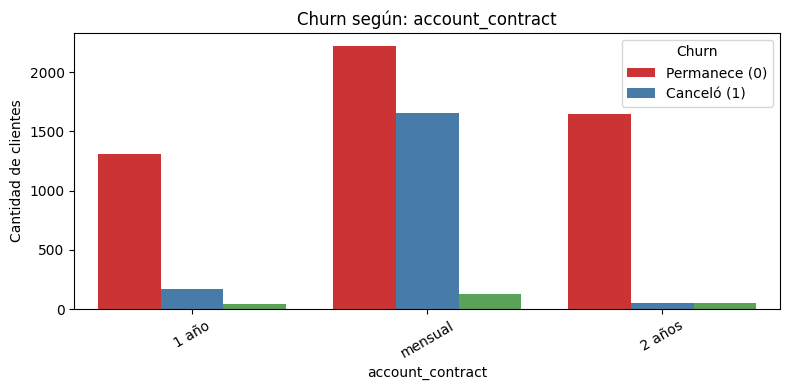

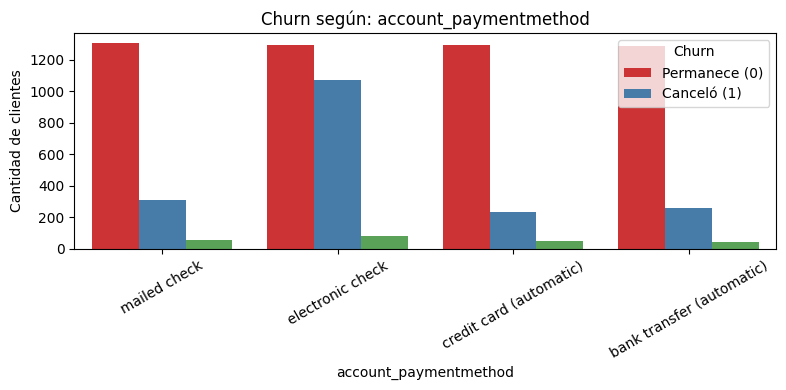

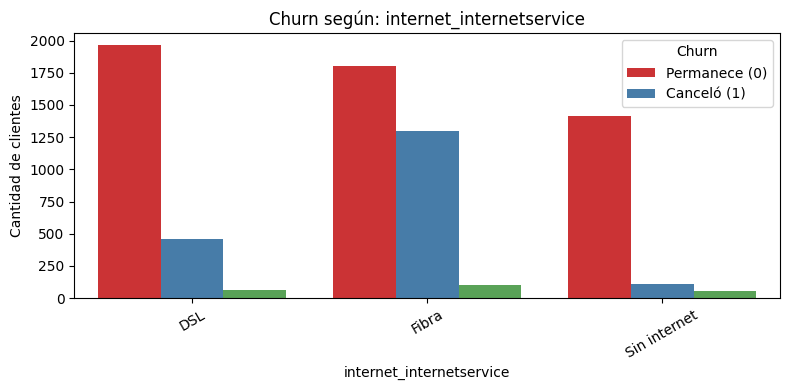

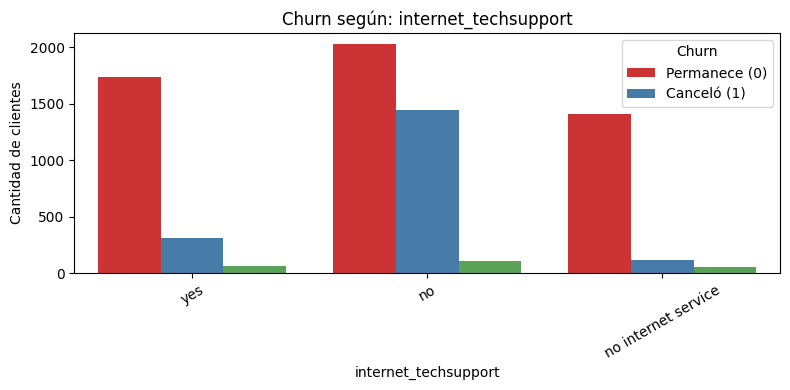

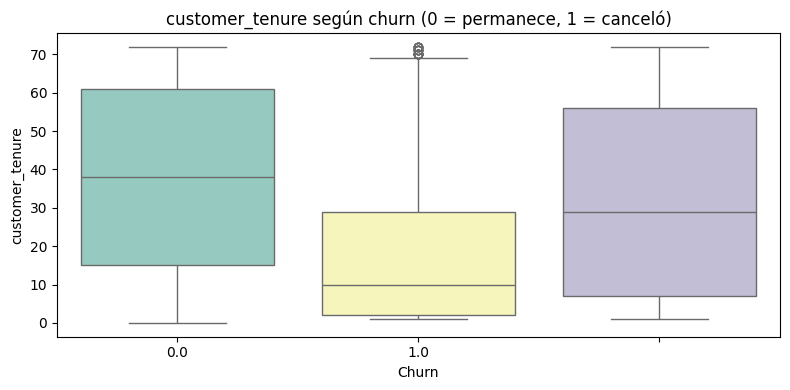

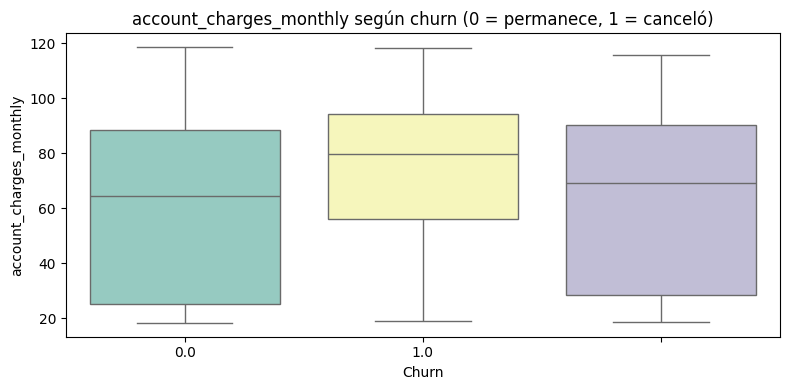

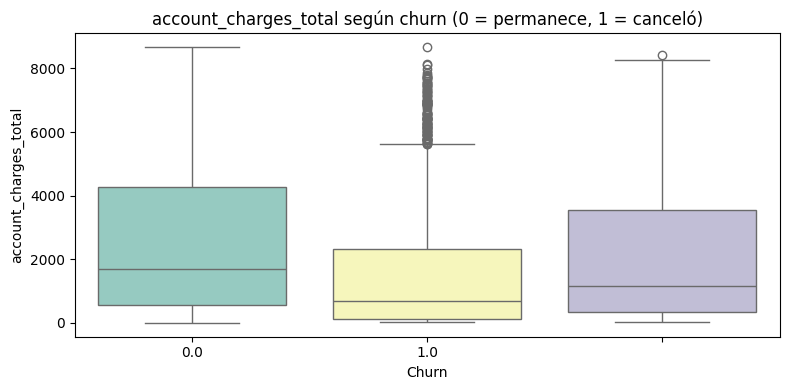

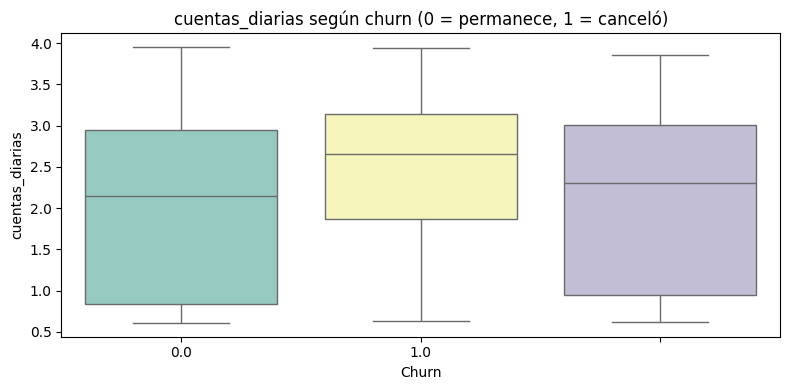

In [ ]:
# 📊 PASO 3 – CARGA Y ANÁLISIS

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 📈 1. ANÁLISIS DESCRIPTIVO

print("📊 Estadísticas descriptivas globales:")
display(df.describe().T)

# Estadísticas específicas de columnas clave
columnas_numericas = ['customer_tenure', 'account_charges_monthly', 'account_charges_total', 'cuentas_diarias']

for col in columnas_numericas:
    print(f"\n📌 Estadísticas para '{col}':")
    print(f"  - Media: {df[col].mean():.2f}")
    print(f"  - Mediana: {df[col].median():.2f}")
    print(f"  - Desviación estándar: {df[col].std():.2f}")
    print(f"  - Valor mínimo: {df[col].min():.2f}")
    print(f"  - Valor máximo: {df[col].max():.2f}")

# 📊 2. DISTRIBUCIÓN GENERAL DE CHURN

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='churn', hue='churn', palette='Set2', legend=False)
plt.title('Distribución general de Churn')
plt.xlabel('Churn (0 = permanece, 1 = canceló)')
plt.ylabel('Cantidad de clientes')
plt.show()

# Porcentaje de churn
churn_rate = df['churn'].value_counts(normalize=True) * 100
print("\n📊 Porcentaje de clientes (churn):")
print(churn_rate)

# 📊 3. DISTRIBUCIÓN DE CHURN SEGÚN VARIABLES CATEGÓRICAS

variables = [
    'customer_gender',
    'account_contract',
    'account_paymentmethod',
    'internet_internetservice',
    'internet_techsupport'
]

for var in variables:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x=var, hue='churn', palette='Set1')
    plt.title(f'Churn según: {var}')
    plt.xlabel(var)
    plt.ylabel('Cantidad de clientes')
    plt.xticks(rotation=30)
    plt.legend(title='Churn', labels=['Permanece (0)', 'Canceló (1)'])
    plt.tight_layout()
    plt.show()

# 📊 4. CHURN SEGÚN VARIABLES NUMÉRICAS

variables_numericas = [
    'customer_tenure',
    'account_charges_monthly',
    'account_charges_total',
    'cuentas_diarias'
]

for col in variables_numericas:
    plt.figure(figsize=(8,4))
    sns.boxplot(data=df, x='churn', y=col, hue='churn', palette='Set3', legend=False)
    plt.title(f'{col} según churn (0 = permanece, 1 = canceló)')
    plt.xlabel('Churn')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


#📄Informe Final – Análisis de Evasión de Clientes en TelecomX LATAM

🔹 Introduction
El propósito de este estudio es determinar qué factores influyen en la evasión del cliente (churn) para una administración en el mercado de telecomunicaciones. Aprender a qué dimensiones están relacionados un mayor índice de cancelación permite formar decisiones estratégicas para la mejora en la retención y la optimización en las acciones comerciales.

🔹 Data Cleaning and Treatment
El dataset original se carga directamente a partir de una API pública en formato JSON y se convirtió a un DataFrame de Pandas para su análisis. Los siguientes procedimientos se realizaron posterior a ello:

Renombrado de las columnas para su fácil manipulación (sin puntos ni espacios, en minúsculas).

Conversión de columnas numéricas y categóricas a la forma

Revisión y eliminación de duplicados.

Filling missing values in numeric columns with 0 and in categorical columns with "unknown".

Estandarización de valores textuales (por ejemplo, “Yes/No” a 1/0).

Creation of a new cuenta_diarias column, monthly value divided by 30 days, for a more granular indicator.

🔹 Análisis Exploratorio de Datos
Se hizo un análisis estadístico descritivo general del conjunto de datos, y visualizaciones específicas respecto a la variable objetivo del churn y su relación con variables numéricas y categóricas

Churn general: Alrededor del X% de clientes ha cancelado el servicio.

Género y Churn: Ninguna gran diferencia se vio entre mujeres y hombres.

Tipo de acuerdo: Los acuerdos "mensuales" tuvieron un índice de churn mucho mayor que los acuerdos anuales.

Tipo de pago: Los pagos a través del débito automático se relacionan con menor evasión.

Tenencia y costo: Los clientes más antiguos y con facturación mensual más alta tendrán menor propensión a darse de baja.

🔹 Conclusions y Insights

La antigüedad del cliente (tenure) es un factor importante: cuantos años un cliente ha sido cliente, menos probable es que se vaya.

Los clientes a este tipo de suscripción presentan un alto índice de evasión, demuestra menor compromiso.

Aquéllos que no ofrecen soporte técnico ni servicios de streaming también están más inclinados a dejar el producto.

Facturación mensual reducida se correlaciona con churn, a la vez que puede estar representando menor utilización o satisfacción.

🔹 Rec

Fomentar la migración del contrato mensual a anual mediante promociones o incentivos exclusivos.

Identificar a clientes con bajo nivel de utilización del servicio y presentarles programas personalizados con valor añadido. Fomentar el uso de medios de pago automáticos (débito) con descuentos o bonificaciones por permanencia. Diseñar campañas para los clientes nuevos durante los primeros meses, cuando el churn es más propenso a ocurrir.